In [34]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np

BASE = Path('.').resolve()
DB_PATH = BASE / "bellabeat_sql_clean_dynamic.db"
OUT = BASE / "outputs" / "plots"
OUT.mkdir(parents=True, exist_ok=True)

plt.rcParams.update({
    "figure.figsize": (10,5),
    "font.size": 10
})


In [35]:
conn = sqlite3.connect(DB_PATH)

cleaned = pd.read_sql("SELECT * FROM cleaned_daily_dedup", conn, parse_dates=["activity_date"])
hourly = pd.read_sql("SELECT * FROM hourly_activity", conn, parse_dates=["activity_hour"])
hourly['activity_hour'] = pd.to_datetime(hourly['activity_hour'])
hourly['hour'] = hourly['activity_hour'].dt.hour
hourly['weekday'] = hourly['activity_hour'].dt.day_name()

# optional tables
try:
    sleep = pd.read_sql("SELECT * FROM cleaned_sleep", conn, parse_dates=["sleep_date"])
except Exception:
    sleep = None
try:
    weight = pd.read_sql("SELECT * FROM cleaned_weight", conn, parse_dates=["log_date"])
except Exception:
    weight = None

conn.close()

# quick type fixes
for col in ["steps","calories","distance","very_active_minutes","moderately_active_minutes","lightly_active_minutes","sedentary_minutes"]:
    if col in cleaned.columns:
        cleaned[col] = pd.to_numeric(cleaned[col], errors='coerce')
hourly['steps'] = pd.to_numeric(hourly['steps'], errors='coerce') if 'steps' in hourly.columns else None
hourly['calories'] = pd.to_numeric(hourly['calories'], errors='coerce') if 'calories' in hourly.columns else None
print(hourly)

C:\Users\anyuser\AppData\Local\Temp\ipykernel_3020\916430447.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  hourly = pd.read_sql("SELECT * FROM hourly_activity", conn, parse_dates=["activity_hour"])


          user_id       activity_hour  steps  calories  hour   weekday
0      1503960366 2016-04-12 00:00:00  373.0       NaN     0   Tuesday
1      1503960366 2016-04-12 01:00:00  160.0       NaN     1   Tuesday
2      1503960366 2016-04-12 02:00:00  151.0       NaN     2   Tuesday
3      1503960366 2016-04-12 03:00:00    0.0       NaN     3   Tuesday
4      1503960366 2016-04-12 04:00:00    0.0       NaN     4   Tuesday
...           ...                 ...    ...       ...   ...       ...
44193  8877689391 2016-05-12 10:00:00    NaN     126.0    10  Thursday
44194  8877689391 2016-05-12 11:00:00    NaN     192.0    11  Thursday
44195  8877689391 2016-05-12 12:00:00    NaN     321.0    12  Thursday
44196  8877689391 2016-05-12 13:00:00    NaN     101.0    13  Thursday
44197  8877689391 2016-05-12 14:00:00    NaN     113.0    14  Thursday

[44198 rows x 6 columns]


In [36]:
print("Rows in cleaned:", len(cleaned))
print("Steps: min/mean/median/max ->", cleaned['steps'].min(), cleaned['steps'].mean(), cleaned['steps'].median(), cleaned['steps'].max())
display(cleaned.describe(include='all').transpose())


Rows in cleaned: 940
Steps: min/mean/median/max -> 0 7637.9106382978725 7405.5 36019


,count,unique,top,freq,mean,min,25%,50%,75%,max,std
user_id,940,33,1503960366,31,NaN,NaN,NaN,NaN,NaN,NaN,NaN
steps,940.0,NaN,NaN,NaN,7637.910638,0.0,3789.75,7405.5,10727.0,36019.0,5087.150742
calories,940.0,NaN,NaN,NaN,2303.609574,0.0,1828.5,2134.0,2793.25,4900.0,718.166862
distance,940.0,NaN,NaN,NaN,5.489702,0.0,2.62,5.245,7.7125,28.030001,3.924606
very_active_minutes,940.0,NaN,NaN,NaN,21.164894,0.0,0.0,4.0,32.0,210.0,32.844803
moderately_active_minutes,940.0,NaN,NaN,NaN,13.564894,0.0,0.0,6.0,19.0,143.0,19.987404
lightly_active_minutes,940.0,NaN,NaN,NaN,192.812766,0.0,127.0,199.0,264.0,518.0,109.1747
sedentary_minutes,940.0,NaN,NaN,NaN,991.210638,0.0,729.75,1057.5,1229.5,1440.0,301.267437
activity_date,940,NaN,NaN,NaN,2016-04-26 06:53:37.021276672,2016-04-12 00:00:00,2016-04-19 00:00:00,2016-04-26 00:00:00,2016-05-04 00:00:00,2016-05-12 00:00:00,NaN


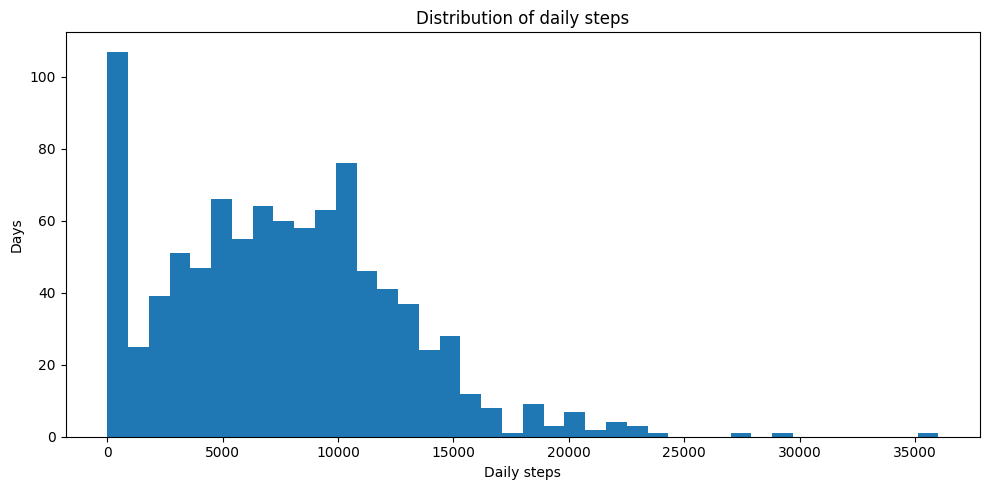

In [37]:
fig, ax = plt.subplots()
data = cleaned['steps'].dropna()
ax.hist(data, bins=40)
ax.set_xlabel("Daily steps")
ax.set_ylabel("Days")
ax.set_title("Distribution of daily steps")
plt.tight_layout()
plt.savefig(OUT / "hist_steps.png", dpi=150)
plt.show()


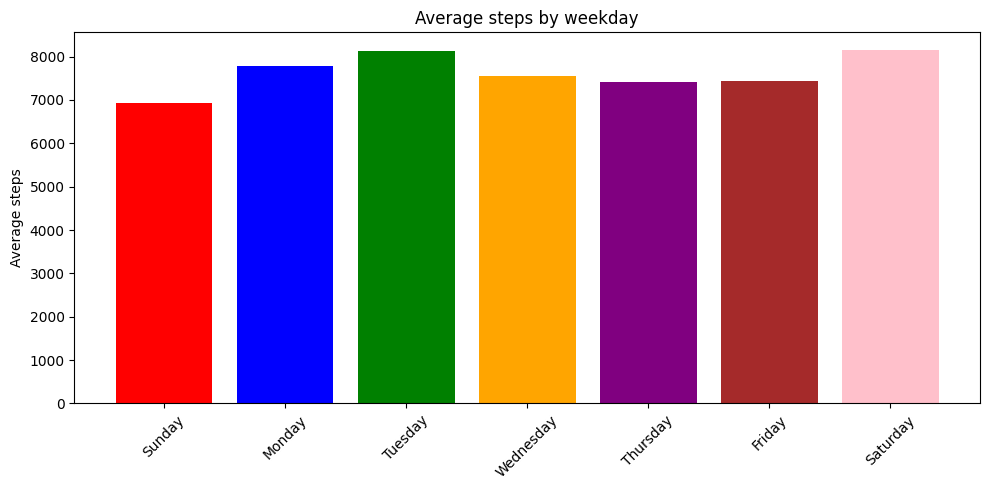

In [ ]:
# ensure activity_date is datetime
cleaned['weekday'] = cleaned['activity_date'].dt.day_name() 
weekday_avg = cleaned.groupby('weekday').agg(avg_steps=('steps','mean'), 
    cnt=('steps','count')).reindex( ["Sunday","Monday","Tuesday","Wednesday","Thursday","Friday","Saturday"] ) 
#fig, ax = plt.subplots() ax.bar(weekday_avg.index, weekday_avg['avg_steps']) 
#ax.set_ylabel("Average steps") 
#ax.set_title("Average steps by weekday") 
#plt.xticks(rotation=45) 
#lt.tight_layout() 
#plt.savefig(OUT / "avg_steps_by_weekday.png", dpi=150) 
#plt.show()

# Define colors for each weekday
weekday_colors = {
    "Sunday": "red",
    "Monday": "blue",
    "Tuesday": "green",
    "Wednesday": "orange",
    "Thursday": "purple",
    "Friday": "brown",
    "Saturday": "pink"
}

# Map colors to the weekday order
colors = [weekday_colors[day] for day in weekday_avg.index]

# Plot with custom colors
fig, ax = plt.subplots()
ax.bar(weekday_avg.index, weekday_avg['avg_steps'], color=colors)
ax.set_ylabel("Average steps")
ax.set_title("Average steps by weekday")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(OUT / "avg_steps_by_weekday.png", dpi=150)
plt.show()



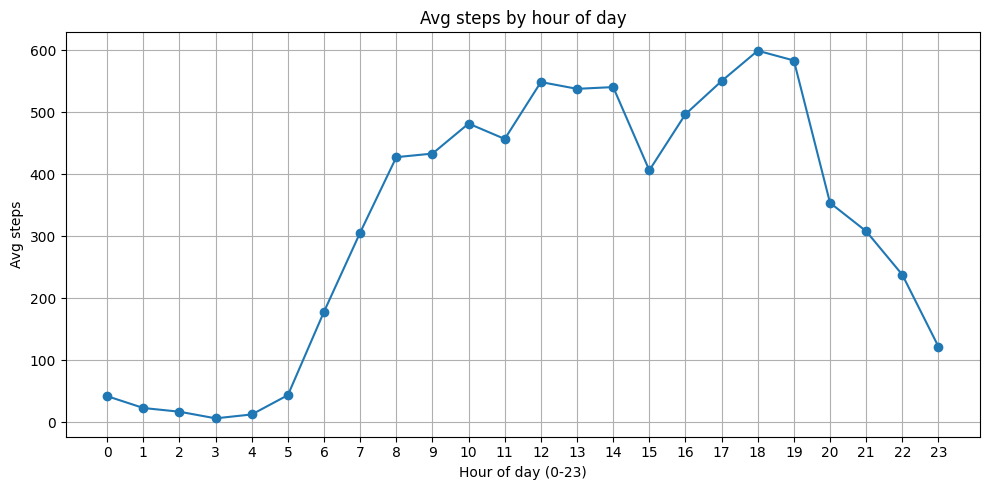

In [39]:
# ensure hour exists and numeric
hourly['hour'] = pd.to_numeric(hourly['hour'], errors='coerce')
hourly_hourly = hourly.groupby('hour').agg(avg_steps=('steps','mean')).reset_index()
fig, ax = plt.subplots()
ax.plot(hourly_hourly['hour'], hourly_hourly['avg_steps'], marker='o')
ax.set_xlabel("Hour of day (0-23)")
ax.set_ylabel("Avg steps")
ax.set_title("Avg steps by hour of day")
ax.set_xticks(range(0, 24))   # ticks at 0,1,2,...,23
plt.grid(True)
plt.tight_layout()
plt.savefig(OUT / "avg_steps_by_hour.png", dpi=150)
plt.show()


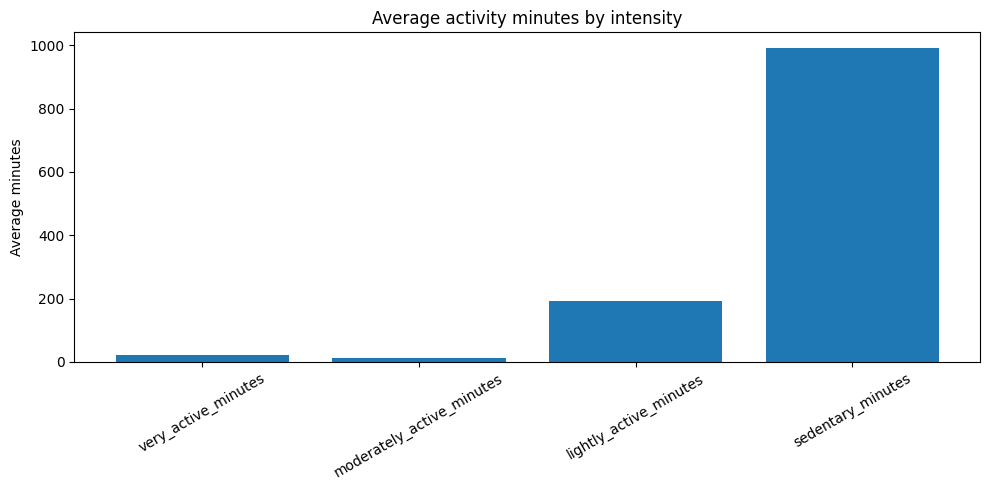

In [40]:
cols = ['very_active_minutes','moderately_active_minutes','lightly_active_minutes','sedentary_minutes']
avgmins = cleaned[cols].mean()
fig, ax = plt.subplots()
ax.bar(cols, avgmins)
ax.set_ylabel("Average minutes")
ax.set_title("Average activity minutes by intensity")
plt.xticks(rotation=30)
plt.tight_layout()
plt.savefig(OUT / "active_minutes_composition.png", dpi=150)
plt.show()


In [41]:
top_users = cleaned.groupby('user_id').agg(avg_steps=('steps','mean'), days=('steps','count')).sort_values('avg_steps', ascending=False).head(20)
display(top_users)
#top_users.to_csv(OUT / "top_users_avg_steps.csv")


,avg_steps,days
user_id,,
8877689391,16040.032258,31
8053475328,14763.290323,31
1503960366,12116.741935,31
2022484408,11370.645161,31
7007744171,11323.423077,26
3977333714,10984.566667,30
4388161847,10813.935484,31
6962181067,9794.806452,31
2347167796,9519.666667,18


In [42]:
if sleep is not None:
    # ensure keys align
    sleep = sleep.rename(columns={'sleep_date':'activity_date'})
    merged = cleaned.merge(sleep[['user_id','activity_date','minutes_asleep']], on=['user_id','activity_date'], how='inner')
    fig, ax = plt.subplots()
    ax.scatter(merged['minutes_asleep'], merged['steps'], s=12, alpha=0.6)
    ax.set_xlabel("Minutes asleep")
    ax.set_ylabel("Steps")
    ax.set_title("Sleep minutes vs Daily steps")
    plt.tight_layout()
    plt.savefig(OUT / "sleep_vs_steps.png", dpi=150)
    plt.show()
else:
    print("No cleaned_sleep table found")


No cleaned_sleep table found


In [43]:
outcsv = BASE / "data" / "exports"
outcsv.mkdir(parents=True, exist_ok=True)
cleaned.to_csv(outcsv/"cleaned_daily_dedup.csv", index=False)
hourly.to_csv(outcsv/"hourly_activity.csv", index=False)
if sleep is not None:
    sleep.to_csv(outcsv/"cleaned_sleep.csv", index=False)
if weight is not None:
    weight.to_csv(outcsv/"cleaned_weight.csv", index=False)
if top_users is not None:
    top_users.to_csv(outcsv/ "top_users_avg_steps.csv")
print("Exports saved to", outcsv)


Exports saved to D:\Edu_Google Data Analytics Professional\Course 8 - Google Data Analytics_Capstone Complete a Case Study - Module 2\C8-M2 Case Study 2 - Capstone\SQL - Fitabase Data 4.12.16-5.12.16\data\exports
